a).

Simulate the model and determine the flux control coefficients for each of the enzymes in the pathway

In [1]:
import numpy as np
from scipy.integrate import odeint

In [2]:
# Define parameters from Figure 5.10
parameters = {
    'Met': 48.5,  # µM
    'V_MATI_max': 561,  # µM/hr
    'V_MATIII_max': 22870,  # µM/hr
    'V_GNMT_max': 10600,  # µM/hr
    'V_MET_max': 4544,  # µM/hr
    'alpha_d': 1333,  # hr^-1
    'K_AHC': 0.1,  
    'adenosine': 1,  # µM
    'K_MATI_m': 41,  # µM
    'K_MATI_i': 50,  # µM
    'K_MATIII_m2': 21.1,  # µM
    'K_GNMT_m': 4500,  # µM
    'K_GNMT_i': 20,  # µM
    'K_MET_m2_div_A': 10  # Dimensionless
}

In [3]:
# Define the differential equations for the pathway
def methionine_metabolism(y, t, params):
    AdoMet, AdoHcy = y

    # MATI reaction rate
    V_MATI = params['V_MATI_max'] / (
        1 + params['K_MATI_m'] / params['Met'] * (1 + AdoMet / params['K_MATI_i'])
    )

    # MATIII reaction rate (allosteric regulation)
    K_MATIII_m1 = 20000 / (1 + 5.7 * (AdoMet / (AdoMet + 600)) ** 2)
    V_MATIII = params['V_MATIII_max'] / (
        1 + (K_MATIII_m1 * params['K_MATIII_m2']) / (params['Met'] ** 2 + params['Met'] * params['K_MATIII_m2'])
    )

    # GNMT reaction rate
    V_GNMT = (
        params['V_GNMT_max'] / (1 + (params['K_GNMT_m'] / AdoMet) ** 2.3)
    ) * (1 / (1 + AdoHcy / params['K_GNMT_i']))

    # MET reaction rate
    K_MAT_m1 = 10 * (1 + AdoHcy / 4)
    V_MET = params['V_MET_max'] / (
        1 + K_MAT_m1 / AdoMet + params['K_MET_m2_div_A'] + (params['K_MET_m2_div_A'] * K_MAT_m1 / AdoMet)
    )

    # Homocysteine consumption (D)
    V_D = params['alpha_d'] * AdoHcy * params['K_AHC'] / params['adenosine']

    # Differential equations
    dAdoMet_dt = V_MATI + V_MATIII - V_GNMT - V_MET
    dAdoHcy_dt = 1 / (1 + params['K_AHC'] / params['adenosine']) * (V_GNMT + V_MET - V_D)

    return [dAdoMet_dt, dAdoHcy_dt]

In [4]:
# Initial concentrations from Figure 5.10
initial_concentrations = {
    'AdoMet': 10,  # µM
    'AdoHcy': 10,  # µM
}

In [5]:
# Time points for simulation
time_points = np.linspace(0, 100, 100000)  # simulate for 100 hours

In [6]:
def model_simulation(parameters, initial_concentrations, time):
    y0 = [initial_concentrations['AdoMet'], initial_concentrations['AdoHcy']]
    results = odeint(methionine_metabolism, y0, time, args=(parameters,))
    return results

In [7]:
results = model_simulation(parameters, initial_concentrations, time_points)
# Extract results
AdoMet_conc = results[:, 0]
AdoHcy_conc = results[:, 1]

In [8]:
# Store results for further analysis
steady_state_AdoMet = AdoMet_conc[-1]
steady_state_AdoHcy = AdoHcy_conc[-1]

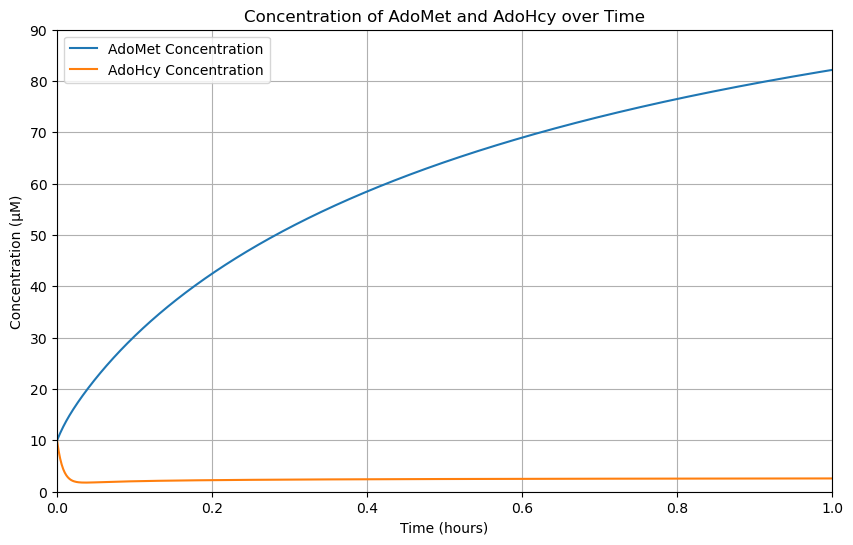

In [9]:
import matplotlib.pyplot as plt

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(time_points, AdoMet_conc, label='AdoMet Concentration')
plt.plot(time_points, AdoHcy_conc, label='AdoHcy Concentration')
plt.xlim(0, 1)
plt.ylim(0, 90)
plt.xlabel('Time (hours)')
plt.ylabel('Concentration (µM)')
plt.title('Concentration of AdoMet and AdoHcy over Time')
plt.legend()
plt.grid(True)
plt.show()

In [10]:
# Define flux equations for each enzyme at steady state
def calculate_fluxes(params, AdoMet, AdoHcy):
    # MATI reaction rate
    V_MATI = params['V_MATI_max'] / (
        1 + params['K_MATI_m'] / params['Met'] * (1 + AdoMet / params['K_MATI_i'])
    )

    # MATIII reaction rate (allosteric regulation)
    K_MATIII_m1 = 20000 / (1 + 5.7 * (AdoMet / (AdoMet + 600)) ** 2)
    V_MATIII = params['V_MATIII_max'] / (
        1 + (K_MATIII_m1 * params['K_MATIII_m2']) / (params['Met'] ** 2 + params['Met'] * params['K_MATIII_m2'])
    )

    # GNMT reaction rate
    V_GNMT = (
        params['V_GNMT_max'] / (1 + (params['K_GNMT_m'] / AdoMet) ** 2.3)
    ) * (1 / (1 + AdoHcy / params['K_GNMT_i']))

    # MET reaction rate
    K_MAT_m1 = 10 * (1 + AdoHcy / 4)
    V_MET = params['V_MET_max'] / (
        1 + K_MAT_m1 / AdoMet + params['K_MET_m2_div_A'] + (params['K_MET_m2_div_A'] * K_MAT_m1 / AdoMet)
    )

    # Homocysteine consumption (D)
    V_D = params['alpha_d'] * AdoHcy * params['K_AHC'] / params['adenosine']
    return V_MATI, V_MATIII, V_GNMT, V_MET, V_D

In [11]:
# Calculate fluxes at steady state
steady_fluxes = calculate_fluxes(parameters, steady_state_AdoMet, steady_state_AdoHcy)

In [12]:
steady_fluxes[0] + steady_fluxes[1], steady_fluxes[2] + steady_fluxes[3], steady_fluxes[4]

(358.679164968098, 358.67916496809966, 358.6791649680998)

In [13]:
# Define control coefficient calculation function
def flux_control_coefficients(params, original_pathway_flux, AdoMet, AdoHcy):
    
    control_coefficients = []

    # Partial derivatives approximated by small perturbations
    perturbation = 0.0001

    # perturbed_fluxes = {
    #     enzyme: calculate_fluxes({**params, enzyme: params[enzyme] * (1 + perturbation)}, AdoMet, AdoHcy)
    #     for enzyme in ['V_MATI_max', 'V_MATIII_max', 'V_GNMT_max', 'V_MET_max', 'alpha_d']
    # }

    enzymes = ['V_MATI_max', 'V_MATIII_max', 'V_GNMT_max', 'V_MET_max', 'alpha_d']

    for i in range(len(enzymes)):
        simulation_results = model_simulation({**params, enzymes[i]: params[enzymes[i]] * (1 + perturbation)}, initial_concentrations, time_points)
        AdoMet_ss = simulation_results[-1, 0]
        AdoHcy_ss = simulation_results[-1, 1]
        perturbed_fluxes = calculate_fluxes({**params, enzymes[i]: params[enzymes[i]] * (1 + perturbation)}, AdoMet_ss, AdoHcy_ss)
        print(perturbed_fluxes[0]+perturbed_fluxes[1], perturbed_fluxes[2]+perturbed_fluxes[3], perturbed_fluxes[4])
        print(original_pathway_flux)

        perturbed_pathway_flux = perturbed_fluxes[4]
        coeff = (perturbed_pathway_flux - original_pathway_flux) * (params[enzymes[i]] / (original_pathway_flux * perturbation * params[enzymes[i]]))
        control_coefficients.append(coeff)


    # Calculate flux control coefficients
    # control_coefficients = {
    #     enzyme: ((perturbed_fluxes[enzyme][0] - V_MATI) / (V_MATI * perturbation))
    #     for enzyme in perturbed_fluxes
    # }

    # control_coefficients = {}
    # for ind in range(len(enzymes)):
    #     enzyme = list(perturbed_pathway_flux.keys())[ind]
    #     control_coefficients[enzyme] = (perturbed_pathway_flux[enzyme] - original_pathway_flux) / (params[enzyme] / (original_pathway_flux * perturbation * params[enzyme]))
    
    return control_coefficients

In [14]:
# Calculate the flux control coefficients
original_pathway_flux = steady_fluxes[-1]
flux_control_coeffs = flux_control_coefficients(parameters, original_pathway_flux, steady_state_AdoMet, steady_state_AdoHcy)

358.68803623554084 358.6880362355383 358.68803623553833
358.6791649680998
358.6909672524539 358.69096725246266 358.6909672524626
358.6791649680998
358.6792331751361 358.679233212921 358.67923321306733
358.6791649680998
358.69350176255284 358.69350177286844 358.69350177285605
358.6791649680998
358.6799561114332 358.6799561113899 358.67995611138974
358.6791649680998


In [15]:
print(flux_control_coeffs, sum(flux_control_coeffs))

[0.2473315515635498, 0.32904850672947294, 0.0019026744281147427, 0.3997111111123869, 0.022057129802527713] 1.000050973636052
